In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
from scipy.optimize import minimize
import scipy.fftpack as fftpack
from tqdm import tqdm

In [62]:
os.chdir('/home/ricky/RNNAE/import_npy')
print('The current working directory is', os.getcwd())

t_all = np.load('Time_all.npy', allow_pickle=True)
m_all = np.load('Magnitude_Abs_all.npy', allow_pickle=True)
m_err_all = np.load('Magnitude_Abs_err_all.npy', allow_pickle=True)
claimedtype_all = np.load('Type_all.npy', allow_pickle=True)
SN_name_all = np.load('SN_name.npy', allow_pickle=True)
print(t_all[0][2])

The current working directory is /home/ricky/RNNAE/import_npy
[-47.  -38.  -35.  -31.9 -29.  -26.  -23.1 -17.  -11.   -5.   -2.    7.
  18.9  34.   60.8  78.8  84.7  90.7  93.7  96.7 108.7 129.7]


In [59]:
class GP:


    def __init__(self, t, m, m_err, type, SN_name, filters, filters_EWM = [4.724, 6.202, 7.673], lc_length_prepeak=-50, lc_length_postpeak=150):

        #filters_EWM = [3.54, 4.724, 6.202, 7.673, 9.05, 10.095]

        self.t = t
        self.m = m
        self.m_err = m_err

        self.type = type
        self.SN_name = SN_name

        self.filters = filters
        self.filters_EWM = filters_EWM

        self.lc_length_prepeak = lc_length_prepeak
        self.lc_length_postpeak = lc_length_postpeak

        self.x = []
        self.y = []
        self.y_err = []
        self.filters_num = []

        self.data_t = []
        self.data_m = [ [] for filter in self.filters]
        self.data_m_err = [ [] for filter in self.filters]

        self.data = [ [] for i in range(1 + len(self.filters)*2)]
        self.data_plot = [ [] for i in range(1 + len(self.filters)*2)]
        self.data_meta = [ [] for i in range(3)]

        self.y_mean = 0
        self.y_range = 0

        for i, filter in enumerate(self.filters):
            for j in range(len(self.t[i])):

                self.x.append(self.t[i][j])
                self.y.append(self.m[i][j])
                self.y_err.append(self.m_err[i][j])
                self.filters_num.append(self.filters_EWM[i])


    def x_GP_pred_generator(self):

        self.t_min = self.t[0][0]
        self.t_max = self.t[0][-1]

        for i in range(len(self.filters) - 1):
            if self.t[i+1][0] < self.t[i][0]:
                self.t_min = self.t[i+1][0]
            if self.t[i+1][-1] > self.t[i][-1]:
                self.t_max = self.t[i+1][-1]

        self.x_tmp = []
        self.filters_num_tmp = []

        for i, filter in enumerate(self.filters):
            self.t_tmp = np.linspace(int(self.t_min), int(self.t_max), int(self.t_max) - int(self.t_min) + 1)
            for j in range(len(self.t_tmp)):
                self.x_tmp.append(self.t_tmp[j])
                self.filters_num_tmp.append(self.filters_EWM[i])

        self.x_GP_pred = np.vstack([self.x_tmp, self.filters_num_tmp]).T

        return self.x_GP_pred


    def lc_padding(self):

        self.lc_len = self.lc_length_postpeak - self.lc_length_prepeak
        self.data_t = np.linspace(int(self.t_min), int(self.t_max), int(self.t_max) - int(self.t_min) + 1)
        self.data_t_len = len(self.data_t)

        for i in range(len(self.filters)):

            self.data_m[i] = self.GP_pred[int((i)*len(self.GP_pred)/len(self.filters)):int((i+1)*len(self.GP_pred)/len(self.filters))]
            self.data_m_err[i] = np.sqrt(self.GP_var[int((i)*len(self.GP_var)/len(self.filters)):int((i+1)*len(self.GP_var)/len(self.filters))])

            for j in range(self.lc_len - len(self.data_m[i])):

                self.data_m[i] = np.append(self.data_m[i], 0)
                self.data_m_err[i] = np.append(self.data_m_err[i], 0)

        for i in range(self.lc_len - self.data_t_len):
            self.data_t = np.append(self.data_t, 0)

        self.data[0] = self.data_t
        for i in range(len(self.filters)):
            self.data[i+1] = self.data_m[i]
        for i in range(len(self.filters)):
            self.data[i+len(self.filters)+1] = self.data_m_err[i]

        self.data_meta[0] = self.data_t_len
        self.data_meta[1] = self.type
        self.data_meta[2] = self.SN_name

        return self.data, self.data_meta


    def normalization(self):

        self.y_mean = np.mean(self.y)
        self.y_range = np.abs(np.max(self.y) - np.min(self.y))

        self.y_err = self.y_err / self.y_range
        self.y = (self.y - self.y_mean) / self.y_range

        return self.y, self.y_err, self.y_mean, self.y_range


    def lc_graph(self, colors = ['darkcyan', 'limegreen', 'crimson']):

        #colors = ['indigo','darkcyan', 'limegreen', 'darkorange', 'crimson', 'maroon']
        
        plt.plot(figsize=(16,12))

        self.data_plot[0] = np.linspace(int(self.t_min), int(self.t_max), int(self.t_max) - int(self.t_min) + 1)

        for i, filter in enumerate(self.filters):

            if self.y_range != 0:
                self.m_tmp = (self.m[i] - self.y_mean) / self.y_range
                self.m_err_tmp = self.m_err[i] / self.y_range

            self.data_plot[i+1] = self.data[i+1][:self.data_meta[-3]]
            self.data_plot[i+len(self.filters)+1] = self.data[i+len(self.filters)+1][:self.data_meta[-3]]

            plt.errorbar(np.array(self.t[i]), np.array(self.m_tmp), np.array(self.m_err_tmp), label=filter, color=colors[i], fmt='.')
            plt.plot(self.data_plot[0], self.data_plot[i+1], label=filter, color = colors[i], alpha=0.8)
            plt.fill_between(self.data_plot[0], self.data_plot[i+1] - self.data_plot[i+len(self.filters)+1], self.data_plot[i+1] + self.data_plot[i+len(self.filters)+1], color=colors[i], alpha=0.2)

        plt.title(f'{self.SN_name}, {self.type}')
        plt.xlim(self.lc_length_prepeak, self.lc_length_postpeak)  
        plt.xlabel('time (day)')
        plt.ylabel('absolute magnitude')
        plt.legend()
        plt.grid()
        plt.gca().invert_yaxis()
        plt.show()
        #plt.savefig(f'/home/ricky/RNNAE/GP_graph/{self.SN_name}.pdf')
        #plt.savefig(fr'C:\\Users\\ricky\\FYP\\RNNAE_public\\GP_graph\\{self.SN_name}.pdf')
        plt.clf()

        return


    def GP_interpolate(self, **kwargs):

        if kwargs['normalization']:
            GP.normalization(self)

        self.x_GP = np.vstack([self.x, self.filters_num]).T

        self.x_GP_pred = GP.x_GP_pred_generator(self)

        self.k1 = np.var(self.y)*kernels.ExpSquaredKernel(metric=[100, 10], ndim=2)
        self.k2 = np.var(self.y)*kernels.ExpKernel(metric=[100, 10], ndim=2)
        self.k = self.k1 + self.k2
        self.gp = george.GP(self.k, white_noise=np.log(np.var(self.y)), fit_white_noise=True)

        self.gp.compute(self.x_GP, self.y_err)

        def neg_ln_like(p):
            self.gp.set_parameter_vector(p)
            return -self.gp.log_likelihood(np.array(self.y))

        def grad_neg_ln_like(p):
            self.gp.set_parameter_vector(p)
            return -self.gp.grad_log_likelihood(np.array(self.y))

        try:
            minimize(neg_ln_like, self.gp.get_parameter_vector(), jac=grad_neg_ln_like, method='L-BFGS-B')
            self.gp.recompute()
            self.GP_pred, self.GP_var = self.gp.predict(self.y, self.x_GP_pred, return_var=True)
        except Exception:
            #print('failed to converge')
            return None, None

        self.data, self.data_meta = GP.lc_padding(self)

        #Final quality check
        diff = 0
        err_ratio = 0

        for i in range(len(self.filters) - 1):

            diff += np.sum(self.data[i+2] - self.data[i+1])
            err_ratio += np.sum(self.data[i+4])

        diff_norm = abs(diff*self.lc_len/self.data_t_len)
        err_ratio_norm = abs(err_ratio*self.lc_len/self.data_t_len)

        if diff_norm/err_ratio_norm < 1:
            return None, None
        else:
            print(f'diff_norm is {diff_norm}')
            print(f'err_ratio_norm is {err_ratio_norm}')
            print(f'diff_norm/err_ratio_norm is {diff_norm/err_ratio_norm}')

        if kwargs['LC_graph']:
            GP.lc_graph(self)

        return self.data, self.data_meta

In [60]:
def main():

    os.chdir('/home/ricky/RNNAE/import_npy')
    #os.chdir(r'C:\\Users\\ricky\\FYP\\RNNAE_public\\import_npy')
    print('Loading in import.npy')

    t_all = np.load('Time_all.npy', allow_pickle=True)
    m_all = np.load('Magnitude_Abs_all.npy', allow_pickle=True)
    m_err_all = np.load('Magnitude_Abs_err_all.npy', allow_pickle=True)
    claimedtype_all = np.load('Type_all.npy', allow_pickle=True)
    SN_name_all = np.load('SN_name.npy', allow_pickle=True)

    os.chdir('/home/ricky/RNNAE/')
    #os.chdir(r'C:\\Users\\ricky\\FYP\\RNNAE_public\\')
    print('Working on GP interpolaiton')

    data_all = [ [] for i in t_all]
    data_meta_all = [ [] for i in t_all]

    for i in tqdm(range(len(t_all))):

        #LC_graph_bool = np.random.rand(1) > 0.99

        data_all[i], data_meta_all[i] = GP(
            t_all[i], m_all[i], m_err_all[i], 
            claimedtype_all[i], SN_name_all[i], 
            ['g', 'r', 'i']
            ).GP_interpolate(
                normalization=True, LC_graph=True
                )
        
        '''if data_all[i] == None:
            print(i)'''
    
    data_all = list(filter(None, data_all))
    data_meta_all = list(filter(None, data_meta_all))

    print(f'There are in total successful {len(data_all)} GP interpolated SNe, and {len(t_all) - len(data_all)} SNe not successful')

    np.save('data_GP.npy', np.array(data_all, dtype=object))
    np.save('data_meta_GP.npy', np.array(data_meta_all, dtype=object))

    print('End of GP.py')

Loading in import.npy
Working on GP interpolaiton


  4%|▍         | 1/25 [00:00<00:03,  6.67it/s]

diff_norm is 108.39211709484525
err_ratio_norm is 11.43413738257977
diff_norm/err_ratio_norm is 9.479693436252015


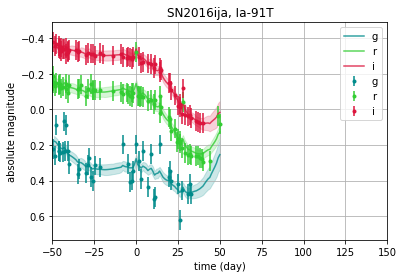

 24%|██▍       | 6/25 [00:01<00:03,  5.72it/s]

diff_norm is 16.80277489627657
err_ratio_norm is 2.2936243846483526
diff_norm/err_ratio_norm is 7.3258616400926915


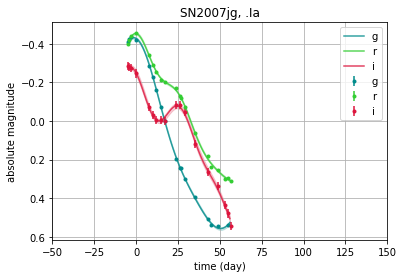

 36%|███▌      | 9/25 [00:01<00:02,  7.16it/s]

diff_norm is 26.198990682392076
err_ratio_norm is 12.521015579901592
diff_norm/err_ratio_norm is 2.0924014122661116


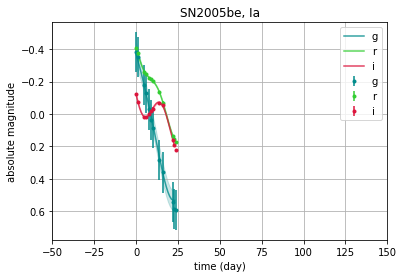

 40%|████      | 10/25 [00:01<00:02,  6.23it/s]

diff_norm is 56.34790582954581
err_ratio_norm is 19.90888865983985
diff_norm/err_ratio_norm is 2.8302888620403324


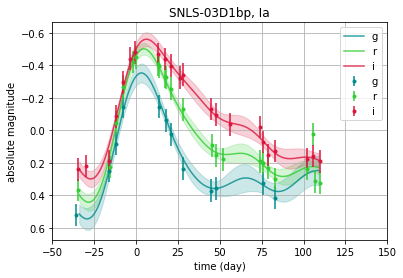

 68%|██████▊   | 17/25 [00:02<00:00,  8.45it/s]

diff_norm is 57.31526714768367
err_ratio_norm is 36.97219022628121
diff_norm/err_ratio_norm is 1.550226448498089


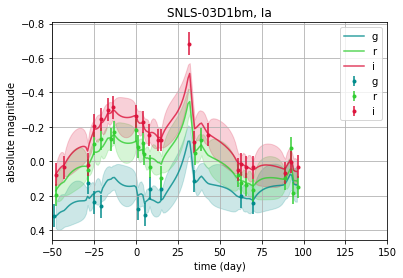

 76%|███████▌  | 19/25 [00:03<00:00,  7.06it/s]

diff_norm is 56.27274077274787
err_ratio_norm is 13.944009880220275
diff_norm/err_ratio_norm is 4.035621120189491


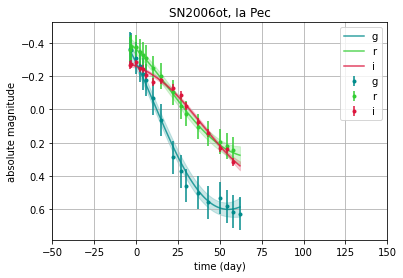

 80%|████████  | 20/25 [00:03<00:00,  6.00it/s]

diff_norm is 97.8216980959379
err_ratio_norm is 25.32195387239525
diff_norm/err_ratio_norm is 3.8631180906848703


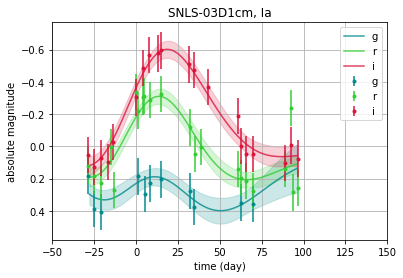

 84%|████████▍ | 21/25 [00:03<00:00,  5.45it/s]

diff_norm is 28.41891892732067
err_ratio_norm is 9.510263429283693
diff_norm/err_ratio_norm is 2.9882367758409365


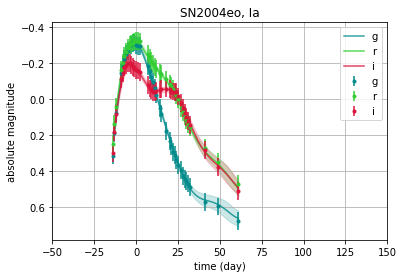

 96%|█████████▌| 24/25 [00:04<00:00,  5.34it/s]

diff_norm is 79.14536961446431
err_ratio_norm is 25.25418128099272
diff_norm/err_ratio_norm is 3.1339511162071285


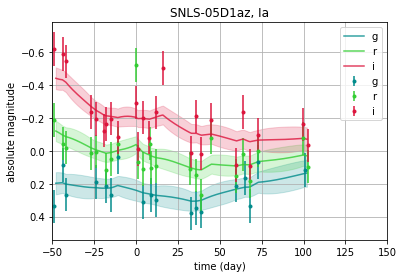

100%|██████████| 25/25 [00:04<00:00,  5.69it/s]

There are in total successful 9 GP interpolated SNe, and 1185 SNe not successful
End of GP.py


<Figure size 432x288 with 0 Axes>

In [61]:
if __name__ == '__main__':
    main()